In [1]:
!pip install earthengine-api geemap rasterio folium --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00


In [2]:
import ee
import geemap
import folium
import rasterio
import numpy as np
from google.colab import files

In [3]:
# Authenticate and initialize Google Earth Engine
import ee
ee.Authenticate()
ee.Initialize(project="ndvi-lst")

In [4]:
roi = ee.Geometry.Polygon(
    [[[78.87011096887923, 20.30015955821763],
      [78.87011096887923, 19.68005289971573],
      [79.63005588465072, 19.68005289971573],
      [79.63005588465072, 20.30015955821763]]]
)

In [5]:
# Load Landsat 8 image collection
landsat = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")
    .filterBounds(roi)
    .filterDate("2023-01-01", "2023-12-31")
    .median()
    .clip(roi)  # Crop to ROI
)

In [6]:
Map = geemap.Map()
Map.centerObject(roi, 8)
Map.addLayer(landsat, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Landsat Image')
Map

Map(center=[19.990307530163108, 79.25008342676527], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
# Compute NDVI
ndvi = landsat.normalizedDifference(['B5', 'B4']).rename('NDVI')

# Display NDVI
ndvi_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
Map.addLayer(ndvi, ndvi_params, 'NDVI')
Map


Map(bottom=58387.0, center=[20.037870053952016, 79.70581054687501], controls=(WidgetControl(options=['position…

In [8]:
# Convert Band 10 to Brightness Temperature (Kelvin)
bt = landsat.select('B10').multiply(0.1)  # Conversion factor from metadata

# Estimate Land Surface Emissivity (LSE)
pv = ndvi.expression('(ndvi - 0.2) / (0.5 - 0.2)', {'ndvi': ndvi}).clamp(0, 1)  # Proportion of vegetation
lse = pv.multiply(0.004).add(0.986)  # Approximate emissivity

# Compute LST using Stefan-Boltzmann equation approximation
lst = bt.expression(
    'bt / (1 + (0.00115 * (bt / 1.438)) * log(e))',
    {'bt': bt, 'e': lse}
).rename('LST')

# Display LST
lst_params = {'min': 290, 'max': 310, 'palette': ['blue', 'yellow', 'red']}
Map.addLayer(lst, lst_params, 'LST')
Map



Map(bottom=116492.0, center=[20.014645445341365, 79.55200195312501], controls=(WidgetControl(options=['positio…

In [9]:
export_task = ee.batch.Export.image.toDrive(
    image=lst,
    description="Chandrapur_Temperature",
    folder="GEE_Exports",
    fileNamePrefix="chandrapur_temperature",
    scale=30,  # Increased scale to reduce file size
    region=roi,
    maxPixels=1e13
)
export_task.start()
print("Export started successfully. Check Google Drive in a few minutes.")


Export started successfully. Check Google Drive in a few minutes.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


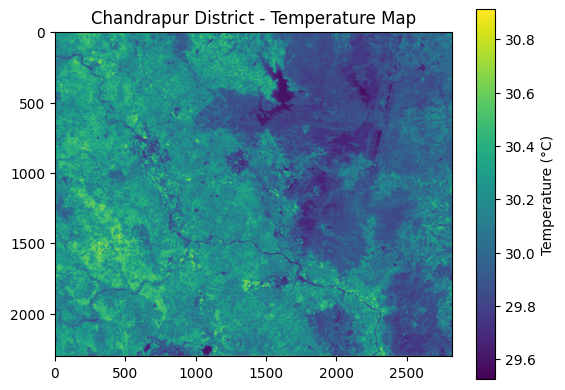

In [12]:
import rasterio
import matplotlib.pyplot as plt

# Load the .tiff file
file_path = "/content/drive/MyDrive/GEE_Exports/chandrapur_temperature.tif"

with rasterio.open(file_path) as src:
    img = src.read(1)  # Read the first band (for single-band images)

plt.imshow(img, cmap='viridis')
plt.colorbar(label='Temperature (°C)')
plt.title('Chandrapur District - Temperature Map')
plt.show()

In [13]:
export_task = ee.batch.Export.image.toDrive(
    image=ndvi,
    description="Chandrapur_NDVI",
    folder="GEE_Exports",
    fileNamePrefix="chandrapur_ndvi",
    scale=30,  # Increased scale to reduce file size
    region=roi,
    maxPixels=1e13
)
export_task.start()
print("Export started successfully. Check Google Drive in a few minutes.")

Export started successfully. Check Google Drive in a few minutes.


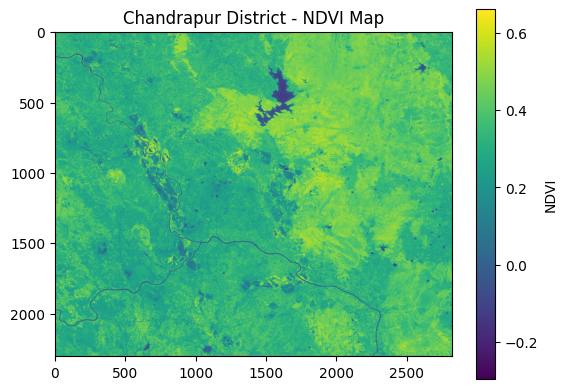

In [14]:
import rasterio
import matplotlib.pyplot as plt

# Load the .tiff file
file_path = "/content/drive/MyDrive/GEE_Exports/chandrapur_ndvi.tif"

with rasterio.open(file_path) as src:
    img = src.read(1)  # Read the first band (for single-band images)

plt.imshow(img, cmap='viridis')
plt.colorbar(label='NDVI')
plt.title('Chandrapur District - NDVI Map')
plt.show()

In [15]:
import seaborn as sns
import pandas as pd

samples = ndvi.addBands(lst).sample(region=roi, scale=30, numPixels=500, seed=42)
df = pd.DataFrame(samples.getInfo()["features"])
df = pd.json_normalize(df["properties"])

correlation = df["NDVI"].corr(df["LST"])
print(f"LST-NDVI Correlation: {correlation:.3f}")


LST-NDVI Correlation: -0.527


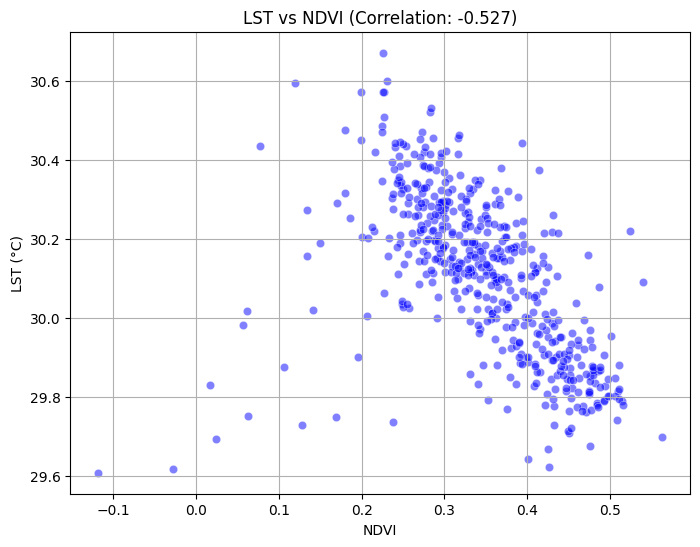

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["NDVI"], y=df["LST"], alpha=0.5, color='blue')
plt.xlabel("NDVI")
plt.ylabel("LST (°C)")
plt.title(f"LST vs NDVI (Correlation: {correlation:.3f})")
plt.grid(True)
plt.show()

In [16]:
def classify_vegetation(ndvi):
    return (ndvi
        .where(ndvi.lt(0), 0)   # Barren / Water
        .where(ndvi.gte(0).And(ndvi.lt(0.2)), 1)   # Sparse Vegetation
        .where(ndvi.gte(0.2).And(ndvi.lt(0.5)), 2)  # Moderate Vegetation
        .where(ndvi.gte(0.5), 3)  # Dense Vegetation
        .rename("VegetationClass")
    )

veg_class = classify_vegetation(ndvi)

veg_vis = {
    "min": 0, "max": 3,
    "palette": ["black", "yellow", "green", "darkgreen"]
}

Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(veg_class, veg_vis, "Vegetation Classification")
Map


Map(center=[19.990307530163108, 79.25008342676527], controls=(WidgetControl(options=['position', 'transparent_…

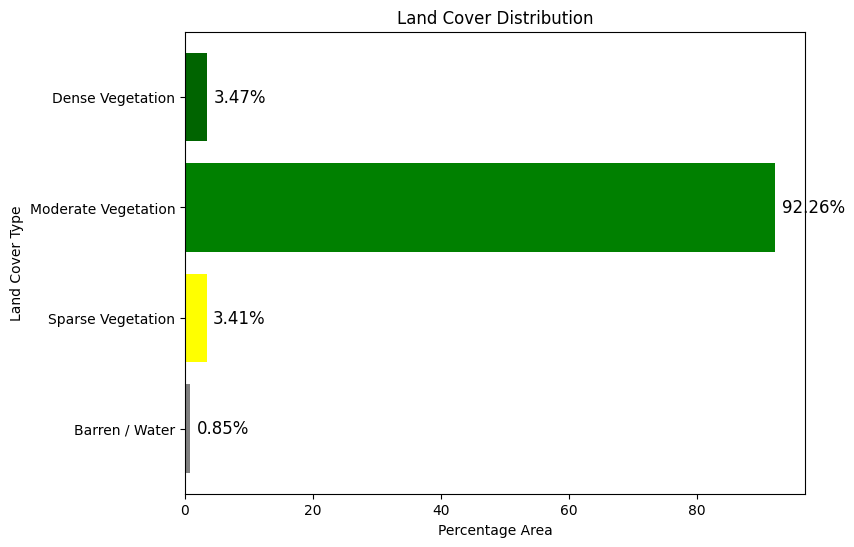

In [17]:
import matplotlib.pyplot as plt

area_img = ee.Image.pixelArea()

# Function to compute land cover area for each class
def compute_land_cover(class_val):
    return (veg_class.eq(class_val)
            .multiply(area_img)
            .reduceRegion(reducer=ee.Reducer.sum(), geometry=roi, scale=30, maxPixels=1e13)
            .get("VegetationClass"))

# Compute land cover areas
land_cover = {
    "Barren / Water": compute_land_cover(0).getInfo(),
    "Sparse Vegetation": compute_land_cover(1).getInfo(),
    "Moderate Vegetation": compute_land_cover(2).getInfo(),
    "Dense Vegetation": compute_land_cover(3).getInfo(),
}

# Calculate percentages
total_area = sum(land_cover.values())
land_cover_percentage = {k: (v / total_area) * 100 for k, v in land_cover.items()}

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.barh(list(land_cover_percentage.keys()), list(land_cover_percentage.values()),
                color=['gray', 'yellow', 'green', 'darkgreen'])

plt.xlabel("Percentage Area")
plt.ylabel("Land Cover Type")
plt.title("Land Cover Distribution")

# Annotate each bar with the percentage value
for bar, percentage in zip(bars, land_cover_percentage.values()):
    plt.text(bar.get_width() + 1,  # Position slightly to the right of the bar
             bar.get_y() + bar.get_height()/2,  # Center vertically
             f"{percentage:.2f}%",  # Format to 2 decimal places
             va='center', fontsize=12, color='black')

plt.show()


In [18]:
# Function to get NDVI range for a given vegetation class
def get_ndvi_range(class_val):
    masked_ndvi = ndvi.updateMask(veg_class.eq(class_val))  # Mask NDVI for this class
    stats = masked_ndvi.reduceRegion(
        reducer=ee.Reducer.minMax(), geometry=roi, scale=30, maxPixels=1e13
    )
    return stats.get("NDVI_min").getInfo(), stats.get("NDVI_max").getInfo()

# Compute NDVI min-max for each vegetation class
ndvi_ranges = {
    "Barren / Water": get_ndvi_range(0),
    "Sparse Vegetation": get_ndvi_range(1),
    "Moderate Vegetation": get_ndvi_range(2),
    "Dense Vegetation": get_ndvi_range(3),
}

# Display results
for class_name, (ndvi_min, ndvi_max) in ndvi_ranges.items():
    print(f"{class_name}: NDVI Range [{ndvi_min:.2f}, {ndvi_max:.2f}]")


Barren / Water: NDVI Range [-0.30, -0.00]
Sparse Vegetation: NDVI Range [0.00, 0.20]
Moderate Vegetation: NDVI Range [0.20, 0.50]
Dense Vegetation: NDVI Range [0.50, 0.66]
